**For cloud environments (Google Colab, Binder, etc.):** Run the following cells to install dependencies and download the neuroimaging dataset from OpenNeuro.

```python
# Install dependencies
!pip3 install -r https://raw.githubusercontent.com/lobennett/bids_neuroimaging_workshop/main/requirements.txt

# Download dataset (Haxby et al., 2001 - face and object recognition)
!wget https://raw.githubusercontent.com/lobennett/bids_neuroimaging_workshop/main/download.sh
!bash download.sh
```

**Note:** The download may take several minutes as the dataset is approximately 1.2GB.

In [ ]:
# Standard library imports
import os
from pathlib import Path

# Third-party imports
from nilearn import plotting, maskers, glm, image
import nibabel as nib
import numpy as np
import pandas as pd
import scipy
import sklearn
from bids import BIDSLayout
from matplotlib import pyplot as plt
from nilearn.glm.first_level import hemodynamic_models
from sklearn.linear_model import LinearRegression


def spm_hrf(TR, p=[6, 16, 1, 1, 6, 0, 32]):
    """An implementation of spm_hrf.m from the SPM distribution

    Arguments:

    Required:
    TR: repetition time at which to generate the HRF (in seconds)

    Optional:
    p: list with parameters of the two gamma functions:
                                                        defaults
                                                        (seconds)
        p[0] - delay of response (relative to onset)      6
        p[1] - delay of undershoot (relative to onset)    16
        p[2] - dispersion of response                     1
        p[3] - dispersion of undershoot                   1
        p[4] - ratio of response to undershoot            6
        p[5] - onset (seconds)                            0
        p[6] - length of kernel (seconds)                 32

    """
    import scipy.stats

    p = [float(x) for x in p]

    fMRI_T = 16.0

    TR = float(TR)
    dt = TR / fMRI_T
    u = np.arange(p[6] / dt + 1) - p[5] / dt
    hrf = (
        scipy.stats.gamma.pdf(u, p[0] / p[2], scale=1.0 / (dt / p[2]))
        - scipy.stats.gamma.pdf(u, p[1] / p[3], scale=1.0 / (dt / p[3])) / p[4]
    )
    good_pts = np.array(range(int(p[6] / TR))) * fMRI_T
    hrf = hrf[list(good_pts.astype(int))]
    hrf = hrf / np.sum(hrf)
    return hrf

### Data organization

The data are stored using a framework called the [Brain Imaging Data Structure](https://bids.neuroimaging.io/) (BIDS), which provides a standard way to organize neuroimaging data. These data can then be queried using the [PyBIDS](https://pypi.org/project/pybids/) Python package.

We will use the dataset from Haxby et al., 2001, which is available from OpenNeuro [ds000105](https://openneuro.org/datasets/ds000105/versions/3.0.0). Here are details about the data (from [PvMVPA](http://www.pymvpa.org/datadb/haxby2001.html)):

>This is a block-design fMRI dataset from a study on face and object representation in human ventral temporal cortex. It consists of 6 subjects with 12 runs per subject. In each run, the subjects passively viewed greyscale images of eight object categories, grouped in 24s blocks separated by rest periods. Each image was shown for 500ms and was followed by a 1500ms inter-stimulus interval. Full-brain fMRI data were recorded with a volume repetition time of 2.5s, thus, a stimulus block was covered by roughly 9 volumes. This dataset has been repeatedly reanalyzed. For a complete description of the experimental design, fMRI acquisition parameters, and previously obtained results see the references below.

In [2]:
# Set up data in PyBIDS layout that was installed from download.sh
bids_dir = Path("./ds000105")
layout = BIDSLayout(bids_dir, derivatives=True)
print(layout)

BIDS Layout: ...neuroimaging_workshop/ds000105 | Subjects: 3 | Sessions: 0 | Runs: 9


First we query for the anatomical image, which is used for overlaying the functional imaging data, and also to align individual brains to a common template.

In [3]:
anat_imgs = layout.get(
    subject=1, extension="nii.gz", suffix="T1w", return_type="filename"
)

print("Found the following anatomical images for sub-1:")
for img in anat_imgs:
    print(img)

# Now let's load the anatomical image and display the header
anat_img_nib = nib.load(anat_imgs[1])
print("The first anatomical image has the following header information:\n")
print(anat_img_nib.header)

Found the following anatomical images for sub-1:
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/anat/sub-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/sub-1/anat/sub-1_T1w.nii.gz
The first anatomical image has the following header information:

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 124 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.     1.2    0.9375 0.9375 1.     0.     0.     0.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 

These data are stored in a common image format known as [NifTI](https://nifti.nimh.nih.gov/nifti-1/), which is the main standard used for neuroimaging data in our field. 

We can display the anatomical image using the Nilearn plotting tools (see nilearn documentation for [plot_anat](https://nilearn.github.io/dev/modules/generated/plotting.plot_anat.html)):

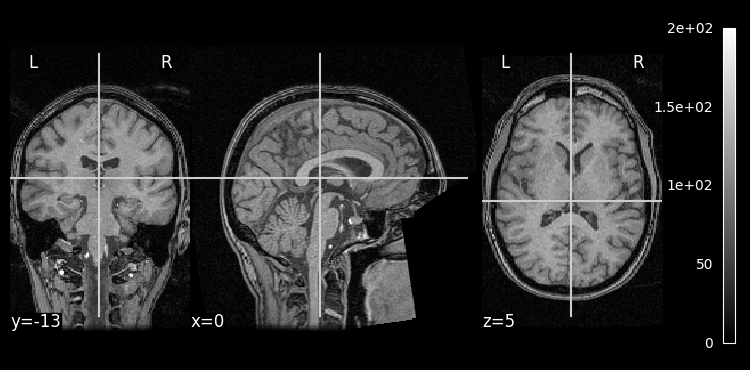

In [4]:
# set vmax to 200 to provide better contrast
plotting.plot_anat(anat_imgs[1], vmax=200)

In [5]:
func_imgs = layout.get(
    subject=1, extension="nii.gz", suffix="bold", return_type="filename"
)

print("Found the following functional images for sub-1:")
for img in func_imgs:
    print(img)

# These images are 4-dimensional.
# We can load their data using the nibabel package (https://pypi.org/project/nibabel/) and inspect its contents:
func_img = nib.load(func_imgs[0])
func_data = func_img.get_fdata()

print(f"Functional image has shape: {func_data.shape}")

Found the following functional images for sub-1:
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/func/sub-1_task-objectviewing_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/func/sub-1_task-objectviewing_run-1_space-T1w_desc-preproc_bold.nii.gz
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/func/sub-1_task-objectviewing_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/func/sub-1_task-objectviewing_run-2_space-T1w_desc-preproc_bold.nii.gz
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/func/sub-1_task-objectviewing_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/func/sub-1_task-objectviewing_ru

The data comprise 121 3D images. The three dimensions refer to left/right, up/down, and front/back.

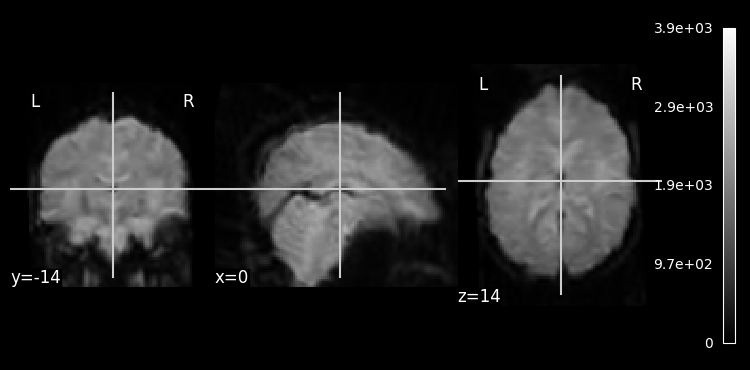

In [6]:
plotting.plot_anat(image.index_img(func_imgs[0], 0))

### Task information
In order to analyze the fMRI data we need to also load the information regarding which stimuli were presented at which times. These are stored according to the BIDS standard in an "events.tsv" associated with each task run. The standard format has three columns that specify the onset of each event (in seconds from the beginning of the run), the duration of the event (in seconds), and a variable called trial_type that specifies the experimental condition.

In [7]:
event_files = layout.get(
    subject=1, extension="tsv", suffix="events", return_type="filename"
)

events = {}
for f in event_files:
    run_num = f.split("_")[-2]
    events[run_num] = pd.read_csv(f, sep="\t")

print(f"Found {len(events)} event files")
events[run_num].head()

Found 3 event files


,onset,duration,trial_type
0,12.0,0.5,cat
1,14.0,0.5,cat
2,16.0,0.5,cat
3,18.0,0.5,cat
4,20.0,0.5,cat


There should be 8 different object types presented in each run:

In [8]:
conditions = events[run_num].trial_type.unique()
print(conditions)

['cat' 'scrambledpix' 'scissors' 'chair' 'bottle' 'shoe' 'face' 'house']


### Analyzing the data using the general linear model (GLM)

The standard approach to anlyzing task fMRI data is to model each experimental condition as a regressor in a general linear model.

Let's create a design matrix that specifies these regressors.

In [9]:
# Get info about timeseries length
n_timepoints = func_img.dataobj.shape[3]
print(n_timepoints, "timepoints")

# Get the length of each image acquisition, known as repetition time or TR
TR = func_img.header.get_zooms()[3]
print("TR:", TR)

121 timepoints
TR: 2.5


We will now create the design matrix for each run, saving each to a dictionary indexed by the run label. We will actually create two design matrices: one is an untransformed representation of the task as a boxcar (with ones during task blocks for each condition and zeros otherwise). We will discuss the second design matrix below.

In [10]:
desmat = {}
desmat_conv = {}

# onset times for each timepoint, in seconds
frame_times = np.arange(0, n_timepoints * TR, TR)

# length of each task block, in seconds
block_length = 24

for run_num, event_df in events.items():
    # first create empty design matrices, to be filled below
    desmat[run_num] = np.zeros((n_timepoints, len(conditions)))
    desmat_conv[run_num] = np.zeros(desmat[run_num].shape)

    for i, cond in enumerate(conditions):
        # create a single block instead of using individual events
        cond_events = events[run_num].query(f'trial_type == "{cond}"')[
            ["onset", "duration"]
        ]
        cond_events["amplitude"] = 1

        # set the first event to the block length, and then remove the rest
        cond_events.iloc[0, 1] = block_length
        cond_events = cond_events.iloc[0, :]

        # create the unconvolved design matrix
        desmat[run_num][:, i] = hemodynamic_models.compute_regressor(
            cond_events.to_numpy()[:, np.newaxis], None, frame_times, oversampling=50
        )[0][:, 0]

        # create the design matrix convolved with the SPM hemodynamic response
        desmat_conv[run_num][:, i] = hemodynamic_models.compute_regressor(
            cond_events.to_numpy()[:, np.newaxis], "spm", frame_times, oversampling=50
        )[0][:, 0]

It is customary to display the design matrix as a image, with timepoints on the vertical axis and conditions on the horizontal axis. In this case, the white blocks represent ones and the black areas represent zeros.

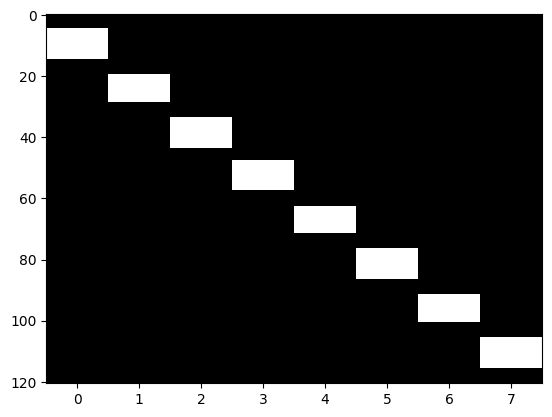

In [11]:
plt.imshow(desmat[run_num], aspect="auto", cmap="gray")

We can also plot these as timeseries, which shows that each has a boxcar form:

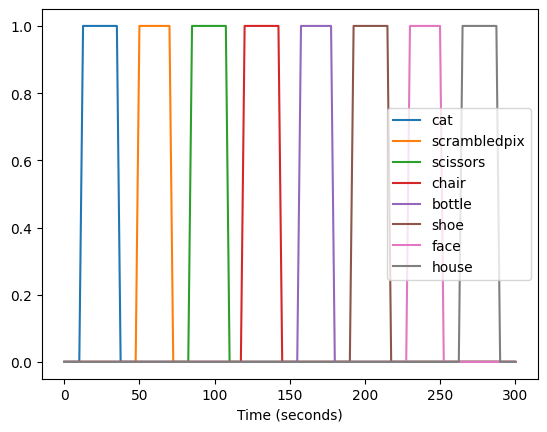

In [12]:
_ = plt.plot(frame_times, desmat[run_num])
plt.xlabel("Time (seconds)")
plt.legend(conditions)

### Hemodynamic convolution

The standard fMRI technique (known as Blood Oxygen Level Dependent or BOLD fMRI) measures changes in MRI signal related to changes in blood oxygen levels, which increase locally when neural activity increases (specifically, when synaptic input increases). This blood flow response is relatively slow, unfolding over seconds. Here is an example from Russ's [Handbook of fMRI Data Analysis](https://www.cambridge.org/core/books/handbook-of-functional-mri-data-analysis/8EDF966C65811FCCC306F7C916228529):

> An example of the hemodynamic responses evoked in area V1 by a contrast-reversing checkerboard displayed for 500 ms. The four different lines are data from four different individuals, showing how variable these responses can be across people. The MRI signal was measured every 250 ms, which accounts for the noisiness of the plots. (Data courtesy of Stephen Engel, University of Minnesota)


![HRF Example](./images/hrf.png)

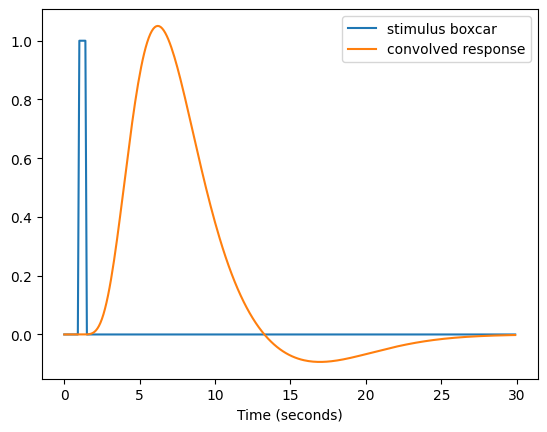

In [13]:
# convolve with hemodynamic response

# boxcar with 100 ms resolution
timepoints = np.arange(0, 30, 0.1)

boxcar = np.zeros(len(timepoints))  # 30 second window
boxcar[10:15] = 1  # 500 ms stimulus starting at 1 second
plt.plot(timepoints, boxcar)
plt.xlabel("Time (seconds)")

# magnify the convolved response by 10 for display purposes
convolved_resp = np.convolve(boxcar, spm_hrf(0.1), mode="full")[: len(timepoints)] * 10
plt.plot(timepoints, convolved_resp)
plt.legend(["stimulus boxcar", "convolved response"])

Because of this hemodynamic delay, we don't expect the BOLD response to stimuli to follow a boxcar function. Rather, we expect that they will be lagged and smeared. Fortunately, there is good evidence to think that the BOLD response is relatively linear (at least for stimul in the range of 0.5-2 secs), so we can simply convolve our boxcar function with a function that represents the shape of the hemodynamic response. One commonly used function is known as the SPM HRF since it is used in the popular SPM software package. It is a combination of two gamma functions, one that models the positive response and a second that models a slower negative response.

Text(0.5, 0, 'Time (secs)')

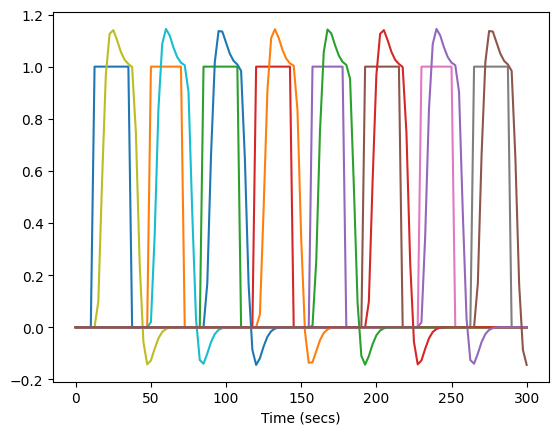

In [14]:
_ = plt.plot(frame_times, desmat[run_num])
_ = plt.plot(frame_times, desmat_conv[run_num])
plt.xlabel("Time (secs)")

### FMRI data preprocessing

We now wish to fit the GLM to data from each run. However, before the fMRI data can be analyzed, they need to be preprocessed to address several issues:
- We need to estimate and correct for head motion across each scan
- We need to estimate a number of other potentia confounding signals, such as physiological fluctuations that relate to breathing or heartbeat, or residual effects of head motion.
- We often want to align each individual's brain with a common template, so that data can be combined across individuals.

To accomplish this we use the [fMRIPrep](https://fmriprep.org/en/stable/) preprocessing workflow:

![fMRIPrep workflow](./images/fmriprep.jpg)

fMRIPrep stores its outputs (known generically as derivatives) in a BIDS format that can also be queried using PyBIDS. Lets find the preprocessed BOLD data (which have been transformed into a common template space known as MNI152NLin2009cAsym), and also find the mask images that tell us for each image which voxels fall within the brain.

In [15]:
# Get the brain mask, adding the 'res' entity
maskfiles = layout.get(
    subject=1,
    desc="brain",
    space="MNI152NLin2009cAsym",
    res="2",
    suffix="mask",
    extension="nii.gz",
    return_type="file",
)

# Check if any mask files were found
if not maskfiles:
    raise ValueError("No mask files found with the specified criteria.")

print(f"Found {len(maskfiles)} mask file(s)")
for mask in maskfiles:
    print(mask)

# Create intersection mask
all_masks = image.concat_imgs(maskfiles)
mask = image.threshold_img(
    image.mean_img(all_masks, copy_header=True), 0.5, copy_header=True
)

# Get the preprocessed BOLD images, adding the 'res' entity
boldfiles = layout.get(
    subject=1,
    desc="preproc",
    space="MNI152NLin2009cAsym",
    res="2",
    suffix="bold",
    extension="nii.gz",
    return_type="file",
)

# Check if any bold files were found
if not boldfiles:
    raise ValueError("No BOLD files found with the specified criteria.")

print(f"Found {len(boldfiles)} bold file(s)")
for bold in boldfiles:
    print(bold)

# Create a mean BOLD image
meanbold = image.mean_img(boldfiles, copy_header=True)
print("\nSuccessfully found and processed all files!")

Found 3 mask file(s)
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/func/sub-1_task-objectviewing_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/func/sub-1_task-objectviewing_run-2_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/func/sub-1_task-objectviewing_run-3_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz
Found 3 bold file(s)
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/func/sub-1_task-objectviewing_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/func/sub-1_task-objectviewing_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/f

Overlay the common mask across runs on top of the subject's anatomical image, this lets you see the areas where fMRI data are missing due to "dropout":

Found the following MNI-coregistered anatomical images for sub-1:
/Users/loganbennett/bids_neuroimaging_workshop/ds000105/derivatives/fmriprep/sub-1/anat/sub-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz


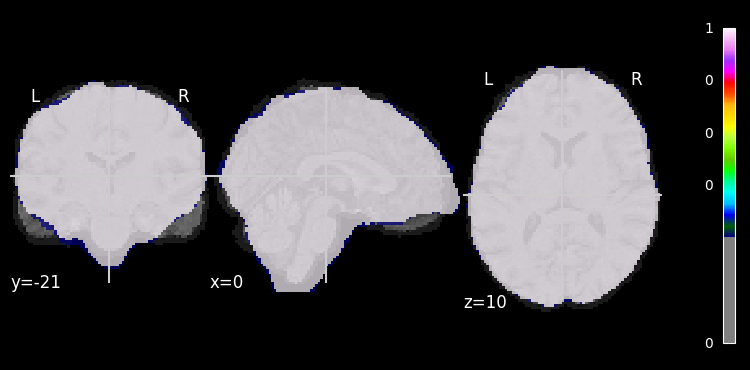

In [16]:
mni_anat_imgs = layout.get(
    subject="1",
    desc="preproc",
    space="MNI152NLin2009cAsym",
    res="2",
    datatype="anat",
    suffix="T1w",
    extension="nii.gz",
    return_type="file",
)

print("Found the following MNI-coregistered anatomical images for sub-1:")
for img in mni_anat_imgs:
    print(img)

bg_image = mni_anat_imgs[0]

plotting.plot_roi(mask, bg_img=bg_image)

Load the data from the in-mask voxels for each run, storing them to a dictionary indexed by runs. Since processed in the data in 3D is inconvenient, we will use the Nilearn NiftiMasker to extract the data from all of the in-mask voxels and return them as a 2D (timepoints X voxels) matrix. We will also load and store a set of confound regressors that are computed by fMRIPrep; these include several estimates of head motion, along with the first 8 principal components of signal from within regions not expected to show BOLD activation, such as the ventricles. The NiftiMasker can then remove these confounds from the data.

Confounds include the following:
- framewise displacement (total motion)
- acompcor (principal components of signals from nuisance areas)
- estimated motion params (translation and rotation and their derivatives)
- cosine bases (modeling low-frequency trends)

In [17]:
# create both full and deconfounded versions of each dataset
bolddata = {}
bolddata_deconfounded = {}
confounds = {}

masker = maskers.NiftiMasker(mask)

confound_vars = ["framewise_displacement"] + [f"a_comp_cor_0{i}" for i in range(8)]
confound_vars += [f"trans_{d}" for d in ["x", "y", "z"]]
confound_vars += [f"rot_{d}" for d in ["x", "y", "z"]]
confound_vars += [f"trans_{d}_derivative1" for d in ["x", "y", "z"]]
confound_vars += [f"rot_{d}_derivative1" for d in ["x", "y", "z"]]
confound_vars += [f"cosine0{i}" for i in range(3)]

for run_num, X in desmat_conv.items():
    print(f"Loading data for {run_num}...")

    confound_file = layout.get(
        subject=1,
        run=int(run_num.split("-")[1]),
        extension="tsv",
        datatype="func",
        suffix="timeseries",
        return_type="filename",
    )[0]

    full_confounds = pd.read_csv(confound_file, sep="\t")
    confounds[run_num] = full_confounds[confound_vars].fillna(0)

    boldfile = layout.get(
        subject=1,
        run=int(run_num.split("-")[1]),
        extension="nii.gz",
        datatype="func",
        suffix="bold",
        return_type="filename",
    )[0]
    bolddata[run_num] = masker.fit_transform(boldfile)
    bolddata_deconfounded[run_num] = masker.fit_transform(
        boldfile, confounds=confounds[run_num]
    )

Loading data for run-01...
Loading data for run-02...
Loading data for run-03...


Combine the data across runs and fit the statistical model, with a separate intercept for each run.

In [18]:
bolddata_concat = None
bolddata_deconfounded_concat = None

X_concat = None

run_idx = 0
for run_num, rundata in bolddata.items():
    if bolddata_concat is None:
        bolddata_concat = bolddata[run_num]
        bolddata_deconfounded_concat = bolddata_deconfounded[run_num]
        X_concat = np.concatenate((desmat_conv[run_num], confounds[run_num]), axis=1)
    else:
        bolddata_deconfounded_concat = np.concatenate(
            (bolddata_deconfounded_concat, bolddata_deconfounded[run_num])
        )
        bolddata_concat = np.concatenate((bolddata_concat, bolddata[run_num]))
        X_concat = np.concatenate(
            (
                X_concat,
                np.concatenate((desmat_conv[run_num], confounds[run_num]), axis=1),
            )
        )

# make intercepts for each run
nruns = len(bolddata)
intercept_mtx = None

for i in range(nruns):
    run_intercept = np.zeros((n_timepoints, nruns))
    run_intercept[:, i] = 1
    if intercept_mtx is None:
        intercept_mtx = run_intercept
    else:
        intercept_mtx = np.concatenate((intercept_mtx, run_intercept))

X_concat = np.append(X_concat, intercept_mtx, axis=1)

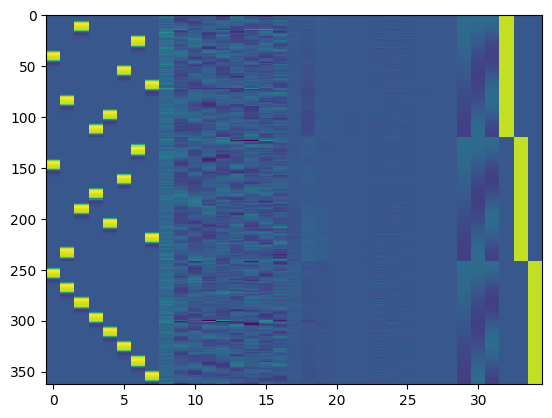

In [19]:
plt.imshow(X_concat, aspect="auto", interpolation="nearest")

In [20]:
lm = LinearRegression()
lm.fit(X_concat, bolddata_concat)

# compute t/p values for each of the condition regressors
# from https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

sse = np.sum((lm.predict(X_concat) - bolddata_concat) ** 2, axis=0) / float(
    X_concat.shape[0] - X_concat.shape[1]
)
se = np.array(
    [
        np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X_concat.T, X_concat))))
        for i in range(sse.shape[0])
    ]
)

t = lm.coef_ / se
p = 2 * (
    1 - scipy.stats.t.cdf(np.abs(t), bolddata[run_num].shape[0] - X_concat.shape[1])
)

# compute r-squared for the full model
rsquared_full = sklearn.metrics.r2_score(
    bolddata_concat, lm.predict(X_concat), multioutput="raw_values"
)

# stored the fitted response
fitted_resp_full = lm.predict(X_concat)

In [21]:
# also fit the model for the confounds only and compute r-squared for each voxel

X_confound = X_concat[:, 8:]
lm.fit(X_confound, bolddata_concat)
rsquared_confound = sklearn.metrics.r2_score(
    bolddata_concat, lm.predict(X_confound), multioutput="raw_values"
)
rsquared_confound_img = masker.inverse_transform(rsquared_confound)

If we plot the r-squared for the confound model, we see that it accounts for a large amount of variance across much of the brain, especially near the edges, where motion is particularly impactful.

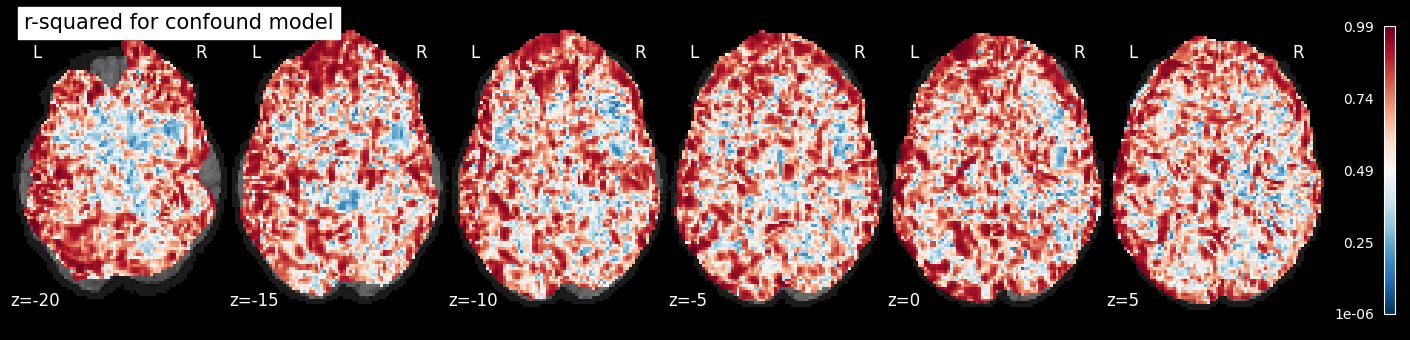

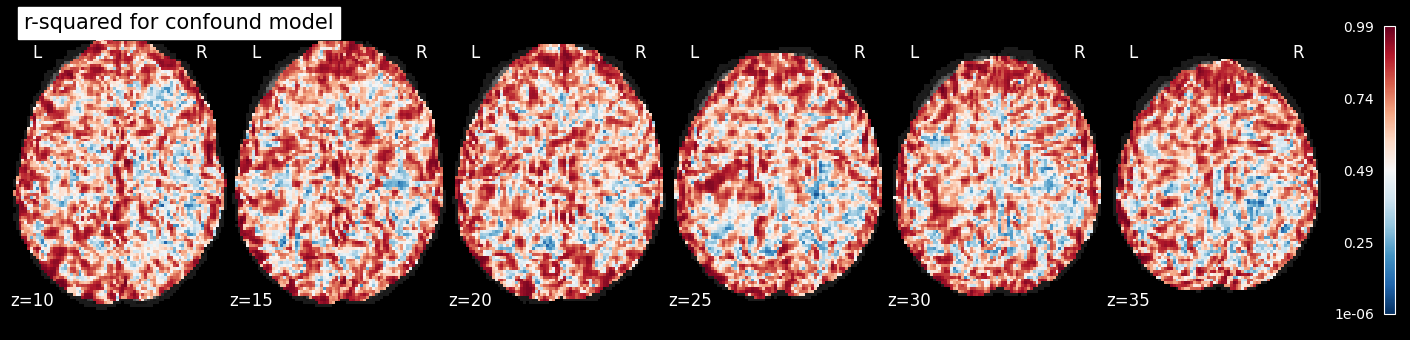

In [22]:
plotting.plot_stat_map(
    rsquared_confound_img,
    bg_image,
    title="r-squared for confound model",
    display_mode="z",
    cut_coords=np.arange(-20, 10, 5),
)
plotting.plot_stat_map(
    rsquared_confound_img,
    bg_image,
    title="r-squared for confound model",
    display_mode="z",
    cut_coords=np.arange(10, 40, 5),
)

To see the added variance accounted for by the task model, we can compute the incremental r-squared, which we see is much more isolated.

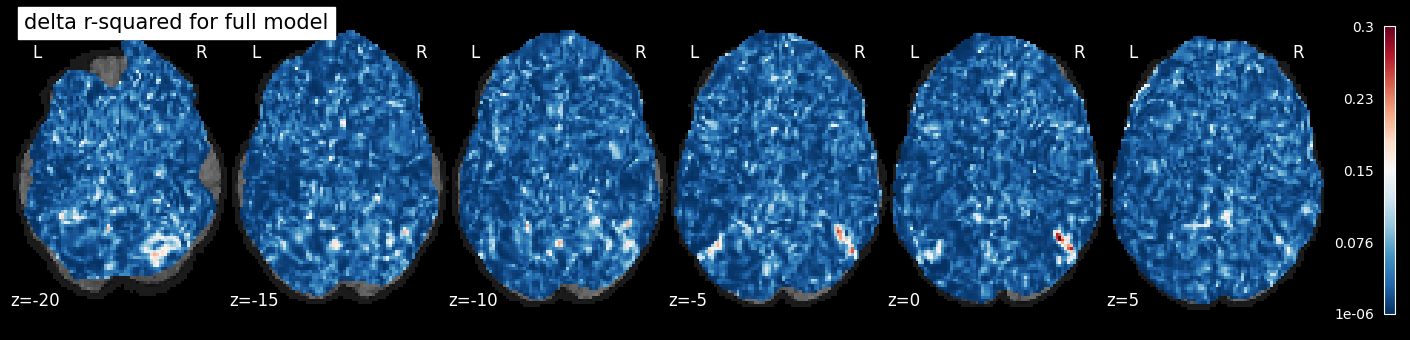

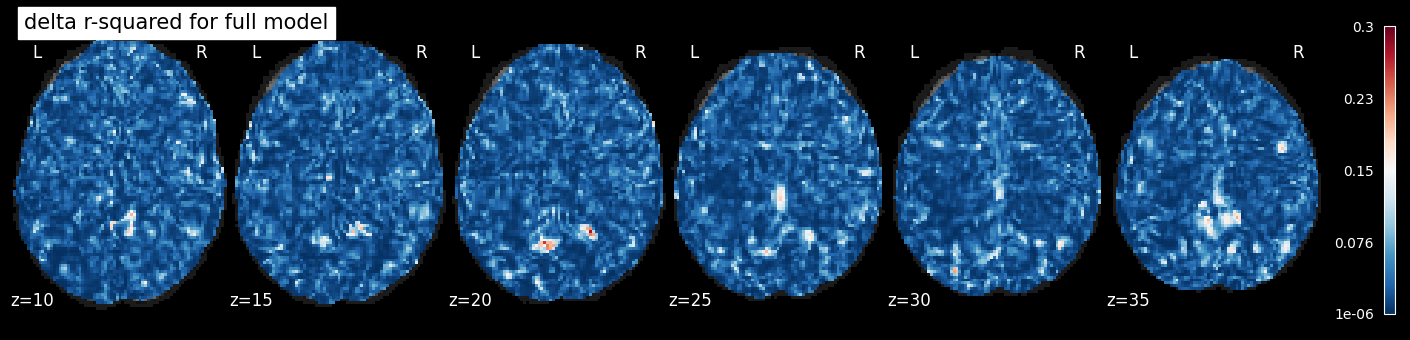

In [23]:
incremental_rsquared_img = masker.inverse_transform(rsquared_full - rsquared_confound)

plotting.plot_stat_map(
    incremental_rsquared_img,
    bg_image,
    title="delta r-squared for full model",
    display_mode="z",
    cut_coords=np.arange(-20, 10, 5),
)
plotting.plot_stat_map(
    incremental_rsquared_img,
    bg_image,
    title="delta r-squared for full model",
    display_mode="z",
    cut_coords=np.arange(10, 40, 5),
)

We can also visualize the statistical maps associated with each condition. We will use the false discovery rate as a rough control for Type I error across the brain, but note that concerns have been raised about the use of FDR in spatially autocorrelated maps like fMRI data ([Chumbley & Friston, 2009](https://pubmed.ncbi.nlm.nih.gov/18603449/)).

In [24]:
tmaps = {}

alpha = 0.001

# convert the 8 condition images back to nifti
for i, cond in enumerate(conditions):
    tmaps[cond] = glm.threshold_stats_img(
        masker.inverse_transform(t[:, i]),
        alpha=alpha,
        cluster_threshold=20,
        height_control="fdr",
    )[0]

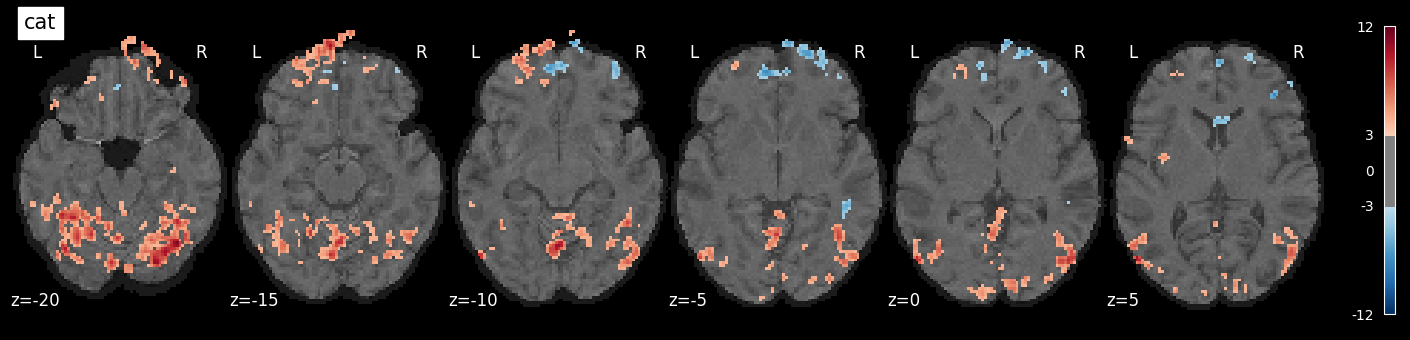

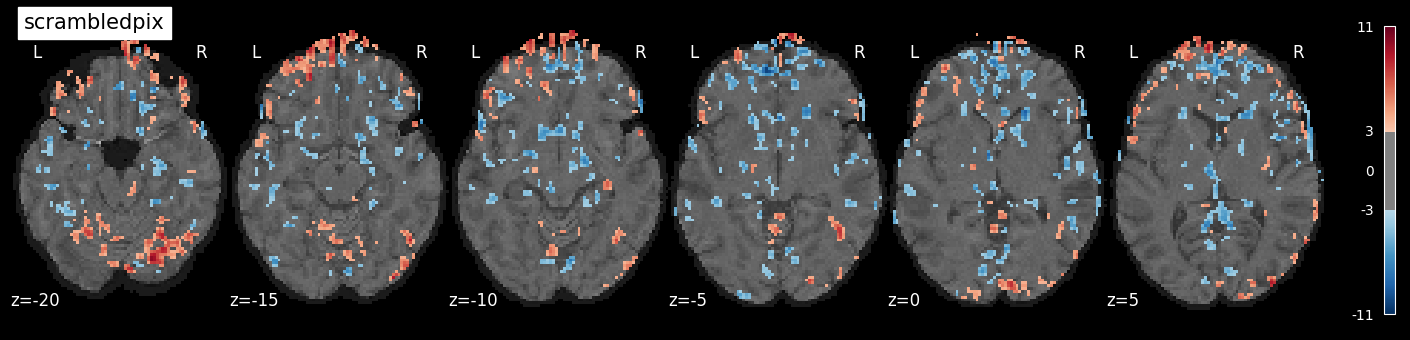

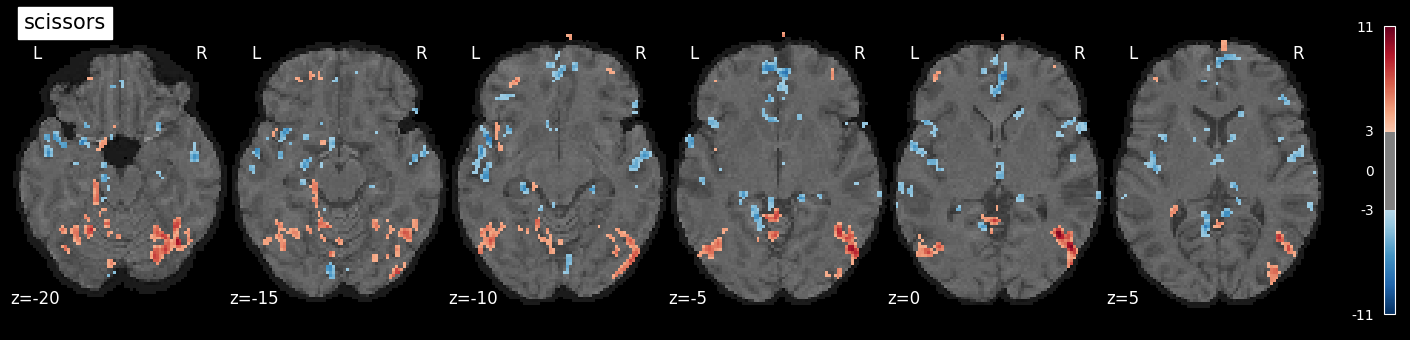

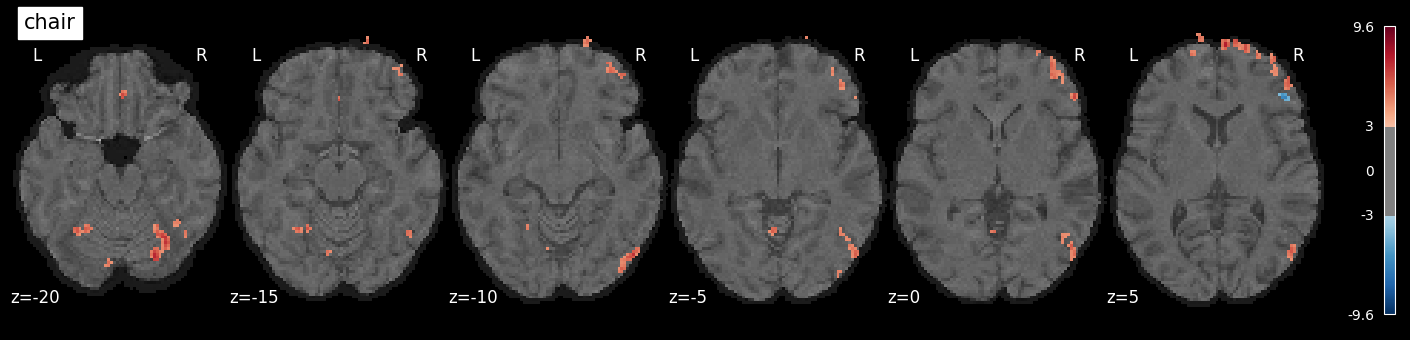

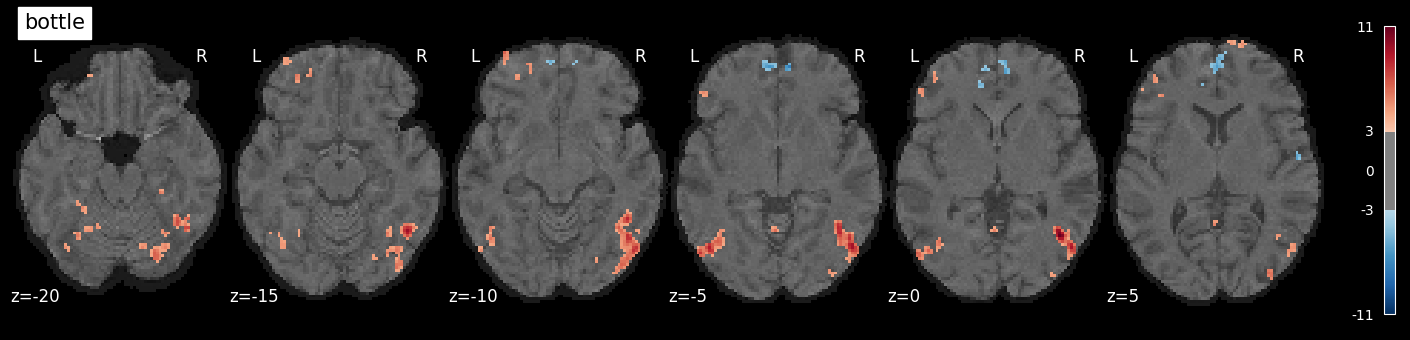

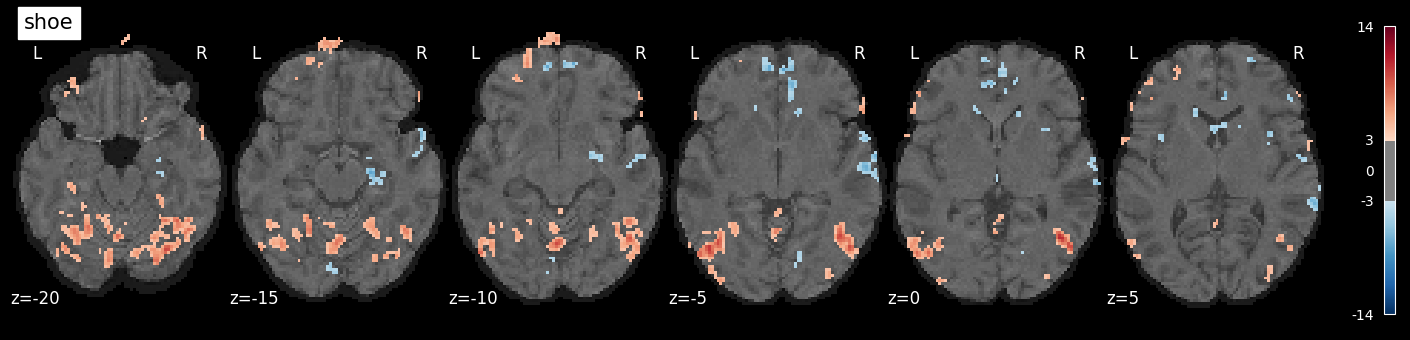

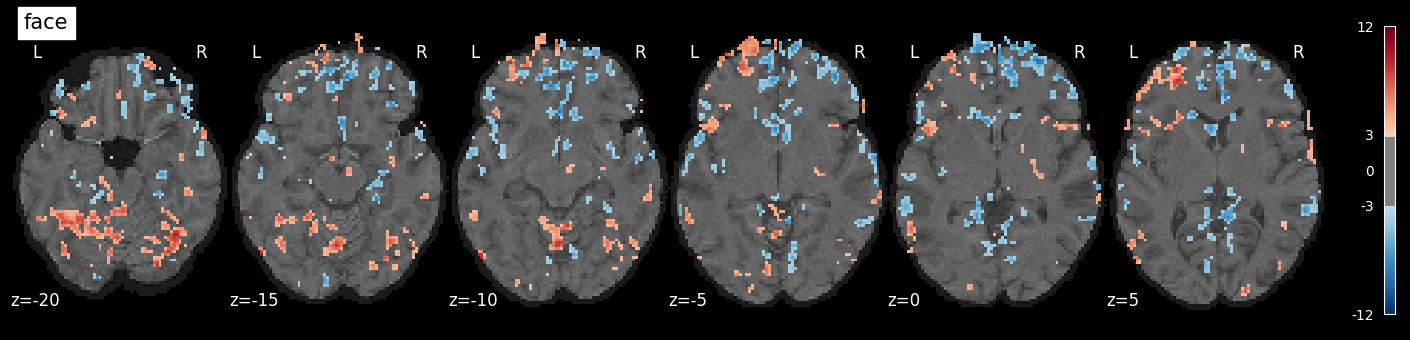

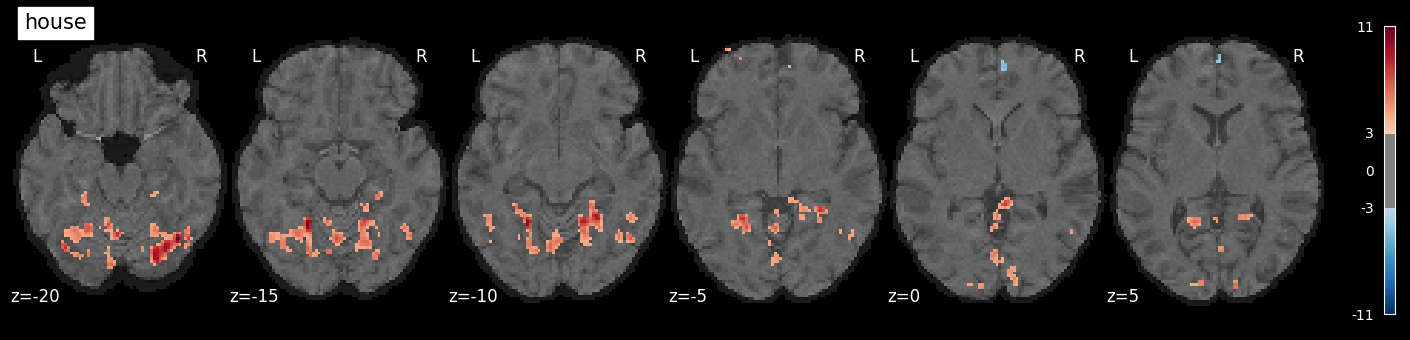

In [25]:
# plot the images
if not os.path.exists("tmaps"):
    os.mkdir("tmaps")

for i, cond in enumerate(conditions):
    plotting.plot_stat_map(
        tmaps[cond],
        bg_image,
        threshold=3.0,
        title=cond,
        display_mode="z",
        cut_coords=np.arange(-20, 10, 5),
    )
    tmaps[cond].to_filename(f"tmaps/{cond}_tmap.nii.gz")

Examine the timeseries from a region of interest

Text(0.5, 1.0, 'Face voxel (r-squared = 0.82)')

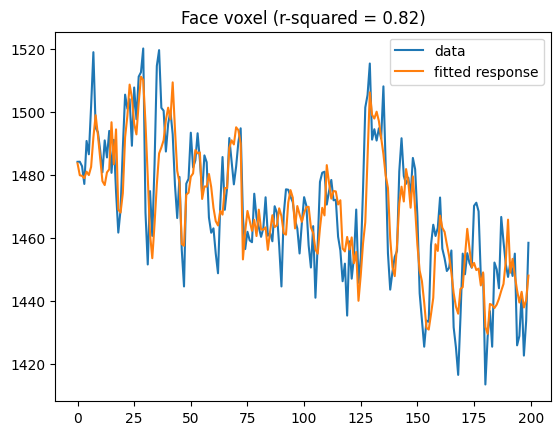

In [26]:
# find highest activating voxel for faces
face_regressor_idx = np.where(conditions == "face")[0][0]
facevox = np.argmax(t[:, face_regressor_idx])

plt.plot(bolddata_concat[:200, facevox])
plt.plot(fitted_resp_full[:200, facevox])
plt.legend(["data", "fitted response"])
plt.title(f"Face voxel (r-squared = {rsquared_full[facevox]:0.2f})")

Text(0.5, 1.0, 'Face voxel (r-squared = 0.97)')

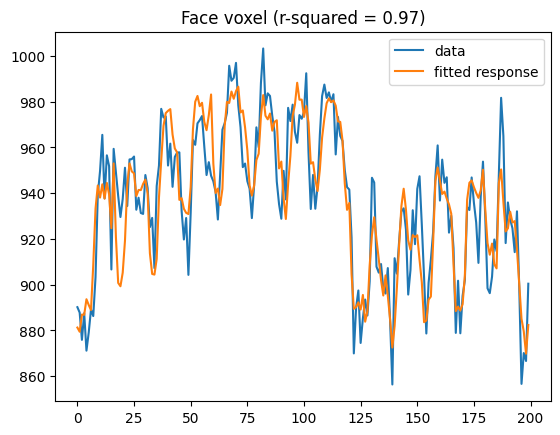

In [27]:
# find highest activating voxel for houses
house_regressor_idx = np.where(conditions == "house")[0][0]
housevox = np.argmax(t[:, house_regressor_idx])

plt.plot(bolddata_concat[:200, housevox])
plt.plot(fitted_resp_full[:200, housevox])
plt.legend(["data", "fitted response"])
plt.title(f"Face voxel (r-squared = {rsquared_full[housevox]:0.2f})")